In [77]:
import requests
path=r'https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-car-sales.csv'
x=requests.get(path)

In [78]:
columns=x.text.split()[0].split(',')
column=[col[1:-1] for col in columns]

In [82]:
from datetime import datetime
date=[]
value=[]
for data in x.text.split()[1:]:
    data=data.split(',')
    dat = data[0][1:-1]
    val= data[1]
    date.append(datetime.strptime(dat,'%Y-%m'))
    value.append(int(val))

In [83]:
data = pd.DataFrame({column[0]:date,
                    column[1]:value})

In [84]:
import pandas as pd

In [88]:
data.to_csv(r'.\monthly-car-sales.csv')

In [89]:
series = pd.read_csv(r'.\monthly-car-sales.csv', header=0, index_col=0)
# summarize shape
print(series.shape)

(108, 2)


In [72]:
import matplotlib.pyplot as plt

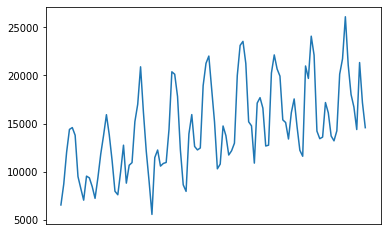

In [90]:
# plot
plt.plot(series.Sales)
plt.xticks([])
plt.show()

# part-1

In [94]:
from math import sqrt
from numpy import median
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot


In [99]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [106]:
# fit a model
def model_fit(train, config):
    return None

def model_predict(model, history, config):
    values = list()
    for offset in config:
        values.append(history[-offset])
    return median(values)

In [116]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error


In [117]:
# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

In [118]:
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()
    
def repeat_evaluate(data, config, n_test, n_repeats=10):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

In [160]:
# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
 > 1841.156
persistence: 1841.156 RMSE (+/- 0.000)


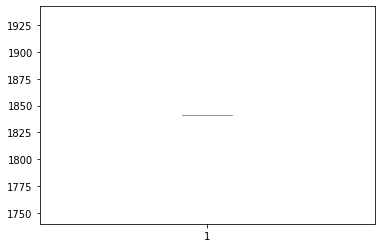

In [123]:
# data split
n_test = 12
data = series.Sales.values
cfg_list = [1, 6, 12, 24, 36]
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 10 configs
for cfg, error in scores[:10]:
print(cfg, error)

# MLP

In [144]:
# evaluate mlp for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

In [145]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    # define model
    model = Sequential()
    model.add(Dense(n_nodes, activation='relu', input_dim=n_input))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _ = config
    # prepare data
    x_input = array(history[-n_input:]).reshape(1, n_input)
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]


In [146]:
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

In [147]:
# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores
# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()

In [ ]:
# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores


# create a list of configs to try
def model_configs():
    # define scope of configs
    n_inputs = [12,24]
    n_nodes = [50, 100]
    n_epochs = [100]
    n_batch = [50,100]
    # create configs
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    cfg = [i, j, k, l, m]
                    configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs


 > 1914.147
 > 1535.514
 > 1090.685
 > 1628.102
 > 1898.567
 > 1480.015
 > 1459.858
 > 1884.212
 > 1487.355
 > 1479.432
 > 1468.215
 > 1617.637
 > 1455.986
 > 1713.757
 > 1555.503
 > 1471.694
 > 1580.996
 > 1553.136
 > 1448.548
 > 1416.868
 > 1434.293
 > 1301.830
 > 1433.214
 > 1551.771
 > 1491.198
 > 1634.214
 > 1629.531
 > 1577.418
 > 1303.438
 > 1524.582
mlp: 1534.057 RMSE (+/- 168.041)


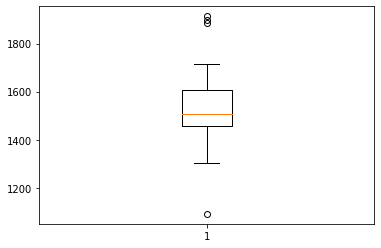

In [148]:
data = series.Sales.values
# data split
n_test = 12
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)


# CNN

In [149]:
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot


# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_filters, n_kernel, n_epochs, n_batch = config
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    # define model
    model = Sequential()
    model.add(Conv1D(n_filters, n_kernel, activation='relu', input_shape=(n_input, 1)))
    model.add(Conv1D(n_filters, n_kernel, activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, _ = config
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()


In [ ]:
# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores


# create a list of configs to try
def model_configs():
    # define scope of configs
    n_input = [12,24]
    n_filters = [64]
    n_kernels = [3, 5]
    n_epochs = [100]
    n_batch = [50,100]
    # create configs
    configs = list()
    for a in n_input:
        for b in n_filters:
            for c in n_kernels:
                for d in n_epochs:
                    for e in n_batch:
                        cfg = [a,b,c,d,e,f]
                        configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

 > 1530.357
 > 1467.585
 > 1587.511
 > 1581.907
 > 1601.163
 > 1591.541
 > 1586.661
 > 1584.918
 > 1515.433
 > 1557.951
 > 1527.424
 > 1521.298
 > 1533.922
 > 1574.771
 > 1469.967
 > 1534.146
 > 1643.166
 > 1513.479
 > 1536.142
 > 1587.312
 > 1483.777
 > 1483.065
 > 1485.587
 > 1633.481
 > 1478.514
 > 1569.842
 > 1447.736
 > 1579.448
 > 1691.581
 > 1463.251
cnn: 1545.431 RMSE (+/- 58.305)


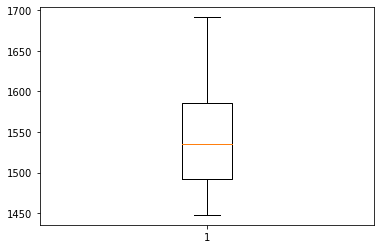

In [150]:
data = series.Sales.values
# data split
n_test = 12
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

# LSTM

In [153]:
# evaluate lstm for monthly car sales dataset
from math import sqrt
from numpy import array,mean,std
from pandas import DataFrame,concat,read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

# fit a model
def model_fit(train, config):
    # unpack config
    n_input, n_nodes, n_epochs, n_batch, n_diff = config
    
    # prepare data
    if n_diff > 0:
        train = difference(train, n_diff)
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, 1)))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_input, _, _, _, n_diff = config
    # prepare data
    correction = 0.0
    if n_diff > 0:
        correction = history[-n_diff]
        history = difference(history, n_diff)
    x_input = array(history[-n_input:]).reshape((1, n_input, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return correction + yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
        
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()


In [ ]:
# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a list of configs to try
def model_configs():
# define scope of configs
n_input = [12,24]
n_nodes = [100]
n_epochs = [50]
n_batch = [1, 150]
n_diff = [12]
# create configs
configs = list()
for i in n_input:
    for j in n_nodes:
        for k in n_epochs:
            for l in n_batch:
                for m in n_diff:
                    cfg = [i, j, k, l, m]
                    configs.append(cfg)
print('Total configs: %d' % len(configs))
return configs

 > 2234.449
 > 2160.683
 > 2198.183
 > 2228.930
 > 2086.028
 > 2102.047
 > 2100.481
 > 2125.519
 > 2205.975
 > 2043.066
 > 2022.694
 > 2066.539
 > 2156.991
 > 2168.615
 > 2048.689
 > 2128.447
 > 1995.061
 > 2139.452
 > 2000.239
 > 2086.070
 > 2072.273
 > 2064.784
 > 2112.171
 > 2135.279
 > 1937.237
 > 2192.143
 > 2145.700
 > 2486.157
 > 2152.554
 > 2120.720
lstm: 2123.906 RMSE (+/- 96.642)


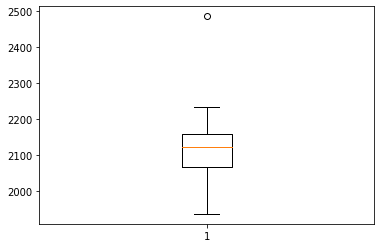

In [154]:
data = series.Sales.values
# data split
n_test = 12
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

# CNN-LSTM

In [156]:
# evaluate cnn-lstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# fit a model
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, n_steps, 1))
    
    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu',
    input_shape=(None,n_steps,1))))
    model.add(TimeDistributed(Conv1D(n_filters, n_kernel, activation='relu')))
    model.add(TimeDistributed(MaxPooling1D()))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(n_nodes, activation='relu'))
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model

# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_seq, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores
    
# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()



In [ ]:
# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a list of configs to try
def model_configs():
    # define scope of configs
    # n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch
    n_seq = [5]
    n_steps = [20]
    n_filters = [50]
    n_kernel = [1, 150]
    n_nodes = [12]
    n_epochs =
    n_batch =[100]
    # create configs
    configs = list()
    for i in n_seq:
        for j in n_steps:
            for k in n_filters:
                for l in n_kernel:
                    for m in n_nodes:
                        for n in n_epochs:
                            for o in n_batch:
                                cfg = [i, j, k, l, m,n,o]
                                configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

 > 1644.419
 > 1312.429
 > 1769.444
 > 1514.419
 > 1414.360
 > 1612.136
 > 1701.861
 > 1545.467
 > 1605.645
 > 1662.447
 > 1744.105
 > 1841.928
 > 1848.595
 > 1637.475
 > 1926.452
 > 2039.456
 > 1518.301
 > 1849.677
 > 1550.482
 > 1644.710
 > 1430.797
 > 1493.792
 > 1698.501
 > 1644.567
 > 1599.084
 > 1592.934
 > 1685.653
 > 1679.387
 > 1813.982
 > 1608.579
cnn-lstm: 1654.369 RMSE (+/- 153.918)


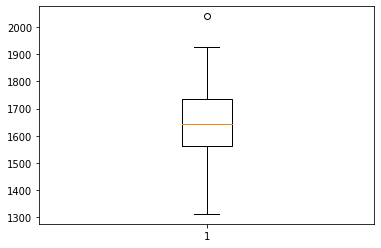

In [157]:
data = series.Sales.values
# data split
n_test = 12
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)

# convLSTM

In [158]:
# evaluate convlstm for monthly car sales dataset
from math import sqrt
from numpy import array
from numpy import mean
from numpy import std
from pandas import DataFrame
from pandas import concat
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from matplotlib import pyplot

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# transform list into supervised learning format
def series_to_supervised(data, n_in, n_out=1):
    df = DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
    # drop rows with NaN values
    agg.dropna(inplace=True)
    return agg.values

# root mean squared error or rmse
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

# difference dataset
def difference(data, interval):
    return [data[i] - data[i - interval] for i in range(interval, len(data))]

# fit a model
def model_fit(train, config):
    # unpack config
    n_seq, n_steps, n_filters, n_kernel, n_nodes, n_epochs, n_batch = config
    n_input = n_seq * n_steps
    # prepare data
    data = series_to_supervised(train, n_input)
    train_x, train_y = data[:, :-1], data[:, -1]
    train_x = train_x.reshape((train_x.shape[0], n_seq, 1, n_steps, 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(n_filters, (1,n_kernel), activation='relu', input_shape=(n_seq, 1,
    n_steps, 1)))
    model.add(Flatten())
    model.add(Dense(n_nodes, activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')
    # fit
    model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch, verbose=0)
    return model


# forecast with a pre-fit model
def model_predict(model, history, config):
    # unpack config
    n_seq, n_steps, _, _, _, _, _ = config
    n_input = n_seq * n_steps
    # prepare data
    x_input = array(history[-n_input:]).reshape((1, n_seq, 1, n_steps, 1))
    # forecast
    yhat = model.predict(x_input, verbose=0)
    return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train, test = train_test_split(data, n_test)
    # fit model
    model = model_fit(train, cfg)
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = model_predict(model, history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    error = measure_rmse(test, predictions)
    print(' > %.3f' % error)
    return error

# repeat evaluation of a config
def repeat_evaluate(data, config, n_test, n_repeats=30):
    # fit and evaluate the model n times
    scores = [walk_forward_validation(data, n_test, config) for _ in range(n_repeats)]
    return scores

# summarize model performance
def summarize_scores(name, scores):
    # print a summary
    scores_m, score_std = mean(scores), std(scores)
    print('%s: %.3f RMSE (+/- %.3f)' % (name, scores_m, score_std))    
    # box and whisker plot
    pyplot.boxplot(scores)
    pyplot.show()
    


In [ ]:
# grid search configs
def grid_search(data, cfg_list, n_test):
    # evaluate configs
    scores = [repeat_evaluate(data, cfg, n_test) for cfg in cfg_list]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# create a list of configs to try
def model_configs():
    # define scope of configs
    n_input = [12,24]
    n_nodes = [100]
    n_epochs = [50]
    n_batch = [1, 150]
    n_diff = [12]
    # create configs
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    for m in n_diff:
                        cfg = [i, j, k, l, m]
                        configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

 > 2509.707
 > 1742.828
 > 2086.749
 > 2298.099
 > 1746.220
 > 2308.123
 > 1982.939
 > 1351.851
 > 1697.518
 > 1853.031
 > 1366.621
 > 2116.268
 > 1504.279
 > 1353.150
 > 1372.406
 > 1501.550
 > 1992.807
 > 1762.277
 > 1599.110
 > 1786.933
 > 1693.094
 > 1921.825
 > 1606.021
 > 1881.303
 > 1779.086
 > 1666.829
 > 1979.084
 > 1403.127
 > 1941.490
 > 1840.109
convlstm: 1788.148 RMSE (+/- 292.555)


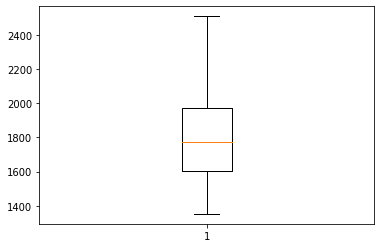

In [159]:
data = series.Sales.values
# data split
n_test = 12
# model configs
cfg_list = model_configs()
# grid search
scores = grid_search(data, cfg_list, n_test)
print('done')
# list top 3 configs
for cfg, error in scores[:3]:
    print(cfg, error)